In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = '') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'Only supporting int/float powers'
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other
    
    def __neg__(self): # -self
        return self * -1
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __radd__(self, other): # other + self
        return self + other

    def __true_div__(self, other):
        return self * other ** -1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f
L.label = 'L'

In [87]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)

    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{%s | data %.4f | grad %.4f}" %(n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

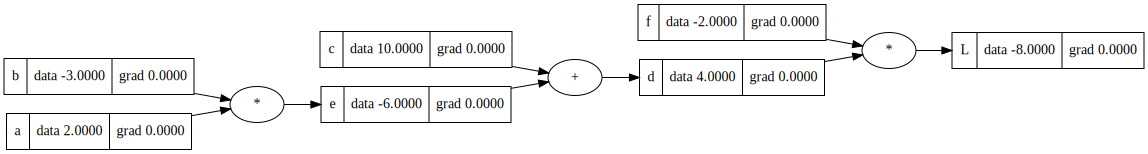

In [66]:
draw_dot(L)

In [67]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = d.grad
e.grad = d.grad
a.grad = b.data * e.grad
b.grad = a.data * e.grad

In [68]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

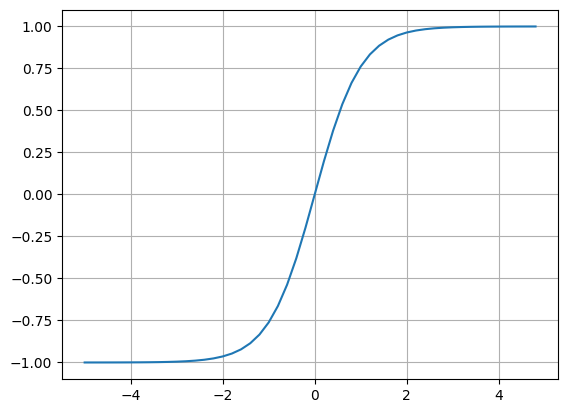

In [69]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [76]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()


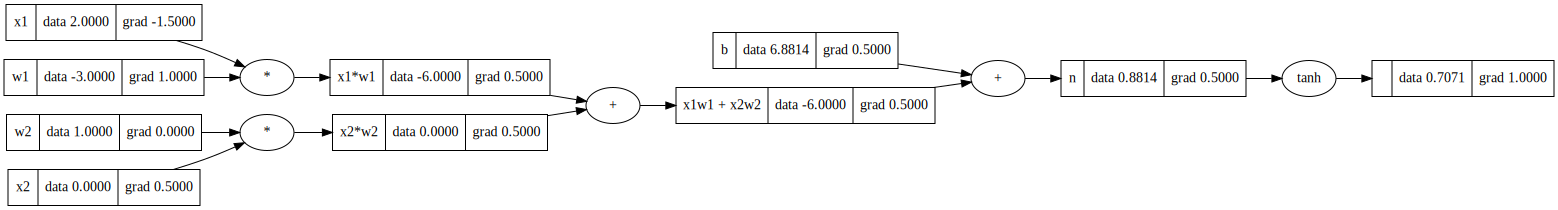

In [79]:
draw_dot(o)

In [78]:
o.backward()

In [72]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [53]:
o.grad = 1.0
n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


In [74]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
o.grad = 1.0
for node in reversed(topo):
    node._backward()

[Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = 0.0),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = -6.0),
 Value(data = 6.881373587019543),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

In [84]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [185]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.2142924890529194)

In [133]:
len(n.parameters())

41

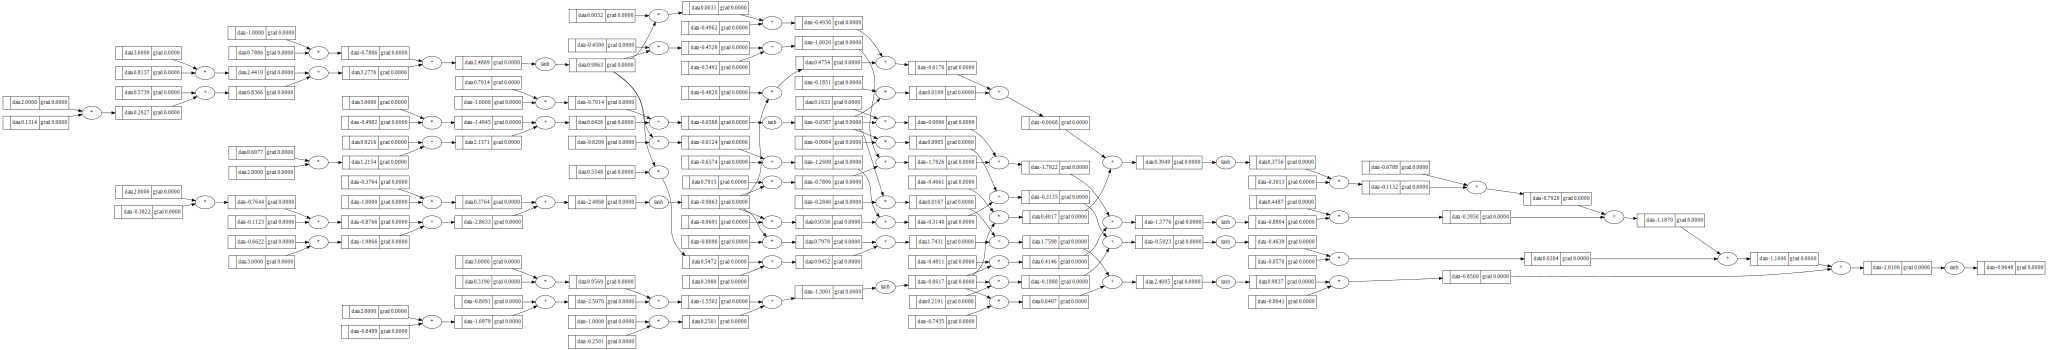

In [110]:
draw_dot(n(x))

In [135]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

ypred

[Value(data = -0.20095579741698497),
 Value(data = -0.5284670077204615),
 Value(data = -0.34846624804469944),
 Value(data = -0.4662916452146152)]

In [206]:
for k in range(20):

    ypred = [n(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])

    for p in n.parameters():
        p.grad = 0

    loss.backward()

    
    
    step_size = 0.01
    for p in n.parameters():
        p.data += -step_size*p.grad

    print(k, loss.data)


0 7.022742442693423e-05
1 7.02254849725882e-05
2 7.022354562291086e-05
3 7.022160637789924e-05
4 7.021966723753858e-05
5 7.021772820182769e-05
6 7.021578927075275e-05
7 7.021385044430619e-05
8 7.021191172247972e-05
9 7.020997310526773e-05
10 7.020803459265936e-05
11 7.020609618464643e-05
12 7.020415788121939e-05
13 7.020221968237192e-05
14 7.02002815880948e-05
15 7.019834359837993e-05
16 7.019640571321754e-05
17 7.019446793260258e-05
18 7.01925302565223e-05
19 7.01905926849709e-05


In [207]:
ypred

[Value(data = 0.9970193897415776),
 Value(data = -0.9969458378694868),
 Value(data = -0.9949952677056744),
 Value(data = 0.9948104621096835)]

In [177]:
ypred = [n(x) for x in xs]

loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data = 0.0017773723234131072)

In [178]:
ypred

[Value(data = 0.9970560373687601),
 Value(data = -0.9792526819908788),
 Value(data = -0.9642354245452522),
 Value(data = 0.9923091388382692)]

In [175]:
loss.backward()

In [176]:
step_size = 0.1
for p in n.parameters():
    p.data += -step_size*p.grad

In [180]:
n.parameters()

[Value(data = -2.0772739042216704),
 Value(data = -0.7887712900928435),
 Value(data = 1.2688161858322715),
 Value(data = -0.5730911116405946),
 Value(data = 0.5402585774917177),
 Value(data = 2.1035165580839603),
 Value(data = -0.0790467267240367),
 Value(data = 0.3569903475731928),
 Value(data = -0.3941542546040425),
 Value(data = 0.9775061909269479),
 Value(data = -1.7712575400464574),
 Value(data = -0.9815277419074329),
 Value(data = -1.0671253324821448),
 Value(data = 1.7160825126350654),
 Value(data = -0.33568034103662864),
 Value(data = -0.14614889215208055),
 Value(data = 0.1608864130833946),
 Value(data = -0.3978582570779151),
 Value(data = 1.0795063357977566),
 Value(data = 0.9950119009801217),
 Value(data = -0.5989484657244),
 Value(data = 0.13966845175143022),
 Value(data = 0.8073274890232732),
 Value(data = -0.7718240638618203),
 Value(data = 0.5552437093113444),
 Value(data = -1.0868826289186868),
 Value(data = -0.17273446148066612),
 Value(data = 0.25483610519516287),
 Va

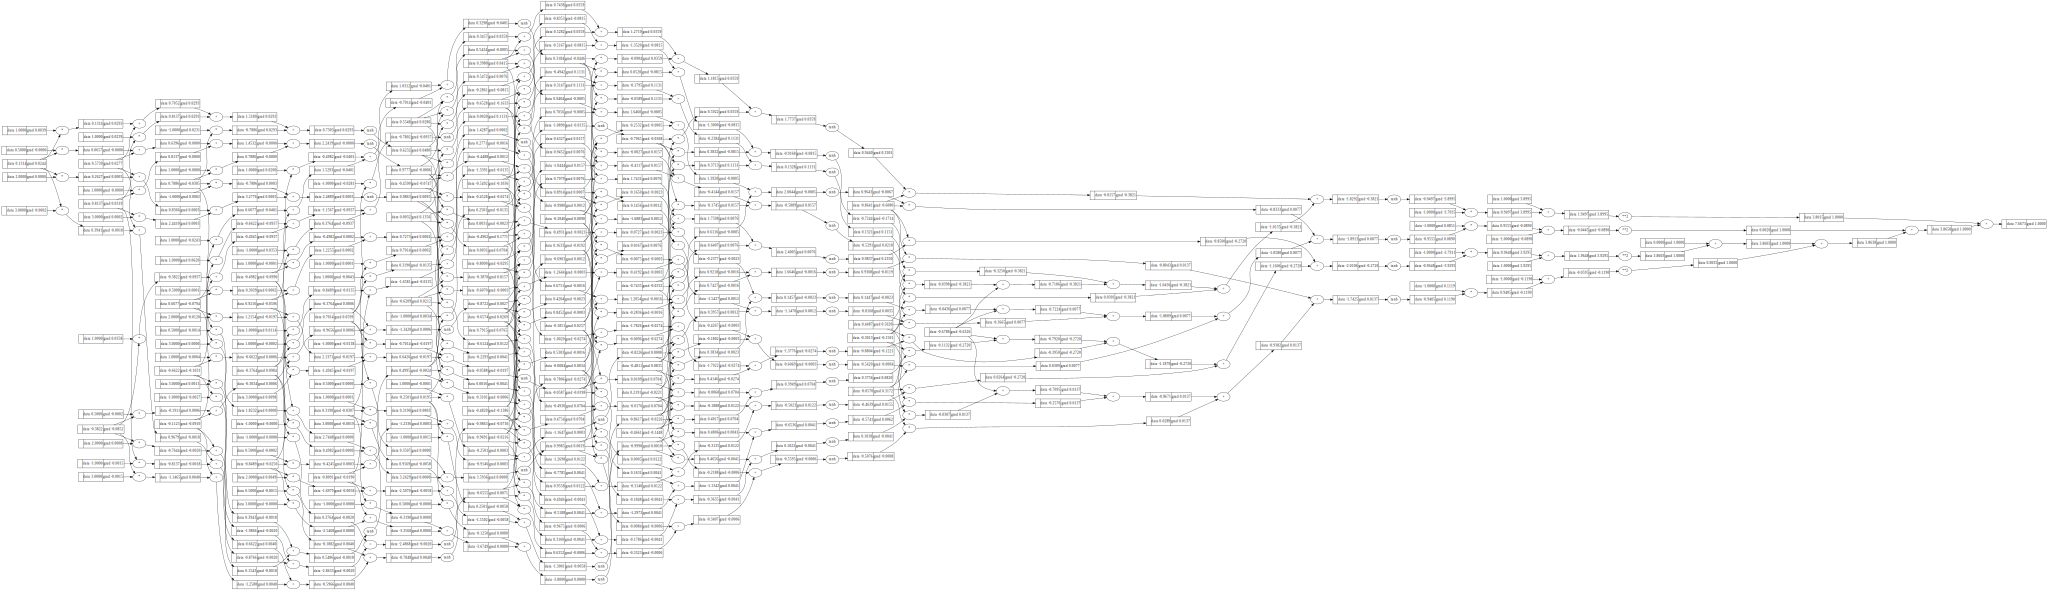

In [130]:
draw_dot(loss)